# Build PyTorch Toy Example

### Basic CNN for MNIST Classification

I've been procrastinating making the move from TensorFlow to PyTorch. Time to jump in and build, train, save, and re-load a basic CNN model on MNIST. First will do it at relatively low-level: loading .csv directly, building Dataset and DataLoader, and creating training loops. My next notebook will take advantage of higher level helpers available in PyTorch.

Instrument with both TensorBoard and Weights & Biases.

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from collections import OrderedDict
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter  # tensorboard
import wandb  # weights and biases

from torchsummary import summary

### Build Dataset and Dataloader

In [20]:
class MNISTDataset(Dataset):
    def __init__(self, data_csv):
        df = pd.read_csv(data_csv)
        self.labels = np.array(df.iloc[:, 0])
        self.features = np.array(df.iloc[:, 1:]).reshape((-1, 1, 28, 28))

    def __len__(self):
        return self.labels.shape[0]

    def __getitem__(self, idx):
        return (
            self.features[idx, ...].astype(np.uint8),
            self.labels[idx]
        )

In [21]:
# pd.read_csv takes either str or Path-like object
p = Path('.') / 'data' / 'MNIST' / 'csv' / 'mnist_train.csv'
training_data = MNISTDataset(p)

p = Path('.') / 'data' / 'MNIST' / 'csv' / 'mnist_test.csv'
test_data = MNISTDataset(p)

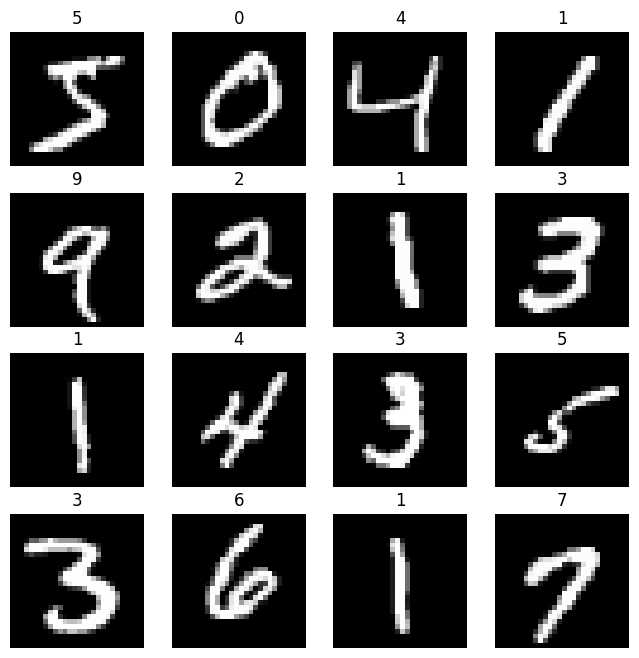

In [22]:
# Quick look at data to make sure it loaded OK
figure = plt.figure(figsize=(8, 8))
cols, rows = 4, 4
for c in range(cols):
    for r in range(rows):
        idx = r + c * cols
        img, label = training_data[idx]
        figure.add_subplot(rows, cols, idx+1)
        plt.title(label)
        plt.axis('off')
        plt.imshow(np.squeeze(img), cmap='gray')
plt.show()

## Create DataLoader from Dataset

In [23]:
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_data, batch_size=64, drop_last=True)

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


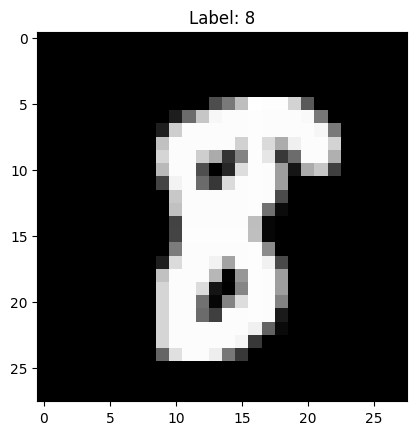

In [24]:
# Quick test of DataLoader: grab a batch and display 1 image
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0]  # grab 1st example from the batch
label = train_labels[0]
plt.imshow(np.squeeze(img), cmap="gray")
plt.title(f"Label: {label}")
plt.show()

## Build CNN Model

In [25]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [26]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        # nn.Sequential accepts OrderedDict if you'd like to give layers meaningful names
        self.cnn_stack = nn.Sequential(OrderedDict([
            ('conv1', nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), stride=2, padding='valid')),
            ('relu1', nn.ReLU()),
            ('conv2', nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding='same')),
            ('relu2', nn.ReLU()),
            ('conv3', nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), stride=2, padding='valid')),
            ('relu3', nn.ReLU()),
            ('avgpool', nn.AdaptiveAvgPool2d(1)),
        ]))
        self.linear_stack = nn.Sequential(OrderedDict([
            ('linear1', nn.Linear(32, 32)),
            ('relu1', nn.ReLU()),
            ('linear2', nn.Linear(32, 10)),
        ]))
        # Give each module a useful name for tracking activations in
        # TensorBoard and Weights & Biases
        for name, module in self.named_modules():
            module.name = name

    def forward(self, x):
        x = x.type(torch.float)
        x = x / 256 - 0.5
        x = self.cnn_stack(x)
        x = torch.squeeze(x)
        logits = self.linear_stack(x)

        return logits

In [27]:
model = CNN().to(device)
print(model)

CNN(
  (cnn_stack): Sequential(
    (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=valid)
    (relu1): ReLU()
    (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (relu2): ReLU()
    (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=valid)
    (relu3): ReLU()
    (avgpool): AdaptiveAvgPool2d(output_size=1)
  )
  (linear_stack): Sequential(
    (linear1): Linear(in_features=32, out_features=32, bias=True)
    (relu1): ReLU()
    (linear2): Linear(in_features=32, out_features=10, bias=True)
  )
)


In [28]:
summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 13, 13]              80
              ReLU-2            [-1, 8, 13, 13]               0
            Conv2d-3           [-1, 16, 13, 13]           1,168
              ReLU-4           [-1, 16, 13, 13]               0
            Conv2d-5             [-1, 32, 6, 6]           4,640
              ReLU-6             [-1, 32, 6, 6]               0
 AdaptiveAvgPool2d-7             [-1, 32, 1, 1]               0
            Linear-8                   [-1, 32]           1,056
              ReLU-9                   [-1, 32]               0
           Linear-10                   [-1, 10]             330
Total params: 7,274
Trainable params: 7,274
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.08
Params size (MB): 0.03
Estimated Total

## Training Loops

Instrumented for both TensorBoard and Weights & Biases to track model parameters, gradients, and activations

In [29]:
def train_loop(dataloader, model, loss_fn, optimizer,
               writer=None, run=None, tb_hook=None, wandb_hook=None, epoch=0):
    model.train()  # put in training mode - important for layers like batchnorm
    batch_size = dataloader.batch_size
    num_batches = len(dataloader)
    num_examples = num_batches * batch_size
    for batch, (X, y) in enumerate(dataloader):
        pred = model(X)
        loss = loss_fn(pred, y)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # logging every 100 batches
        if batch % 100 == 0:
            batch_loss, current = loss.item(), batch * batch_size
            print(f"loss: {batch_loss:.3f} [{current}/{num_examples}]")
            step = batch + num_batches * epoch
            
            # TensorBoard - histogram of all activations
            if writer:
                with torch.nn.modules.module.register_module_forward_hook(tb_hook(writer, step)):
                    model(X)
                writer.add_scalar("Loss/train", batch_loss, global_step=step)
                
            # Weights & Biases - histogram of all activations
            if run:
                with torch.nn.modules.module.register_module_forward_hook(wandb_hook(run, step)):
                    model(X)
                run.log({"train_loss": batch_loss}, step=step, commit=True)
            
    return step

def test_loop(dataloader, model, loss_fn, writer=None, run=None, step=0):
    model.eval()  # put in evaluation mode - important for layers like batchnorm
    batch_size = dataloader.batch_size
    num_batches = len(dataloader)
    num_examples = num_batches * batch_size
    total_loss, num_correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            y_hat = model(X)
            total_loss += loss_fn(y_hat, y).item()
            num_correct += (y_hat.argmax(dim=1) == y).sum().type(torch.float).item()
            
    test_loss = total_loss / num_batches
    accuracy = num_correct / num_examples
    print(f"Test Error: \n Accuracy= {accuracy * 100:.1f}%, Loss = {test_loss:.3f}\n")
    # TensorBoard
    if writer:
        writer.add_scalar("Loss/test", test_loss, global_step=step)
        writer.add_scalar("Accuracy/test", accuracy * 100, global_step=step)
    # Weights & Biases
    if run:
        run.log({"test_loss": test_loss, "test_accuracy": accuracy * 100}, step=step+1, commit=True)

In [30]:
learning_rate = 1e-1
batch_size = 64
epochs = 5
model = CNN().to(device)

run = wandb.init(
    project="mnist",
    config={
    "learning_rate": learning_rate,
    "architecture": "CNN",
    "dataset": "MNIST",
    "epochs": epochs,
    }
)

run.watch(model, log='all')
writer = SummaryWriter()

def tb_hook(writer, step):
    """ Tensorboard histogram hook. """
    def hook(module, input, output):
        writer.add_histogram(str(module.name), output, global_step=step)

    return hook

def wandb_hook(run, step):
    """ Weights & Biases histogram hook. """
    def hook(module, input, output):
        run.log({module.name: wandb.Histogram(output.detach())}, step=step)

    return hook

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

for epoch in range(epochs):
    print(f"Epoch {epoch}\n--------------------------")
    step = train_loop(train_dataloader, model, loss_fn, optimizer,
                      writer, run, tb_hook, wandb_hook, epoch)
    test_loop(test_dataloader, model, loss_fn, writer, run, step)

# close Weights & Biases tracker
run.unwatch()
run.finish()
# close TensorBoard tracker
writer.flush()
writer.close()

wandb: Currently logged in as: pcoady00. Use `wandb login --relogin` to force relogin


Epoch 0
--------------------------
loss: 2.328 [0/59968]
loss: 2.321 [6400/59968]
loss: 2.296 [12800/59968]
loss: 2.303 [19200/59968]
loss: 2.294 [25600/59968]
loss: 2.296 [32000/59968]
loss: 2.269 [38400/59968]
loss: 2.198 [44800/59968]
loss: 2.152 [51200/59968]
loss: 1.974 [57600/59968]
Test Error: 
 Accuracy= 25.3%, Loss = 2.025

Epoch 1
--------------------------
loss: 1.913 [0/59968]
loss: 2.110 [6400/59968]
loss: 1.853 [12800/59968]
loss: 2.154 [19200/59968]
loss: 2.002 [25600/59968]
loss: 1.878 [32000/59968]
loss: 1.964 [38400/59968]
loss: 2.015 [44800/59968]
loss: 1.956 [51200/59968]
loss: 1.880 [57600/59968]
Test Error: 
 Accuracy= 39.9%, Loss = 1.634

Epoch 2
--------------------------
loss: 1.844 [0/59968]
loss: 1.332 [6400/59968]
loss: 1.132 [12800/59968]
loss: 1.177 [19200/59968]
loss: 0.788 [25600/59968]
loss: 0.837 [32000/59968]
loss: 0.693 [38400/59968]
loss: 0.800 [44800/59968]
loss: 0.545 [51200/59968]
loss: 0.403 [57600/59968]
Test Error: 
 Accuracy= 86.9%, Loss = 0.

test_accuracy,▁▂▇██
test_loss,█▇▂▁▁
train_loss,███████▇▇▇▆▇▇▇▇▇▆▅▄▄▃▃▃▂▂▂▂▂▁▂▂▁▁▂▂▂▂▁▁▁
test_accuracy,94.34095
test_loss,0.18143
train_loss,0.1159


## Save and Re-load model

In [13]:
# save trained model
torch.save(model, 'model.pth')
print('performance with above trained model')
test_loop(test_dataloader, model, loss_fn)

performance with above trained model
Test Error: 
 Accuracy= 94.4%, Loss = 0.194



In [14]:
print('performance with newly initialized (random) model')
model = CNN().to(device)
test_loop(test_dataloader, model, loss_fn)

performance with newly initialized (random) model
Test Error: 
 Accuracy= 9.8%, Loss = 2.306



In [15]:
# load model, and test peformance, should match above
model = torch.load('model.pth')
test_loop(test_dataloader, model, loss_fn)

Test Error: 
 Accuracy= 94.4%, Loss = 0.194

